# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()

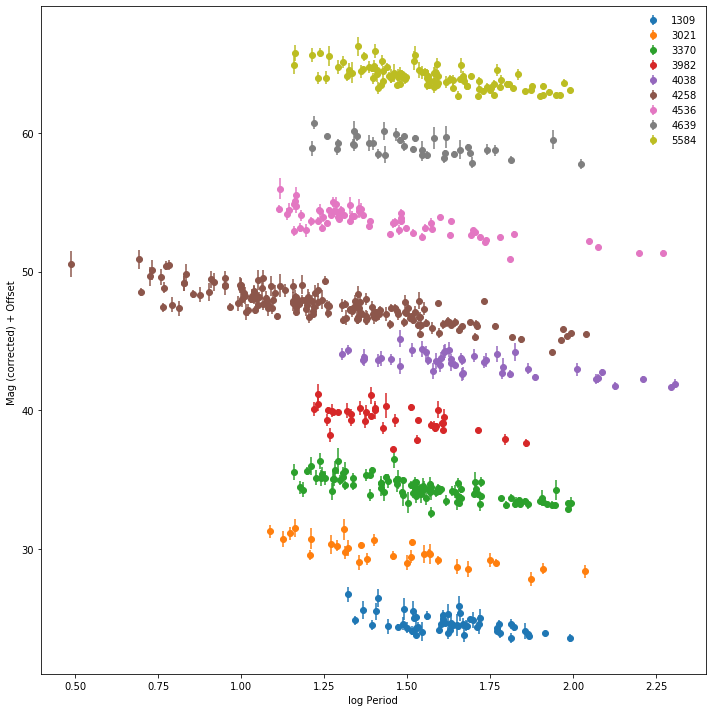

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


The model (Eq.1 from Riess et al. with metallicity ignored as the above instruction suggests) is: $$m^{\rm model}_{i,j} \equiv m_{W,i,j} = (\mu_{0,i}-\mu_{0,4258}) + zp_{W,4258} + b_{W}{\rm log}P_{i,j}$$

where i and j express the j-th Cepheid magnitude in the i-th host.

Given points ($m^{\rm obs}_{i,j}$) with error bars ($\sigma_{i,j}$), "assuming Gaussian magnitude errors and no period error" suggests likelihood for each one data point:

$$P(m^{\rm obs}_{i,j}|m^{\rm model}_{i,j},\sigma_{i,j}) = \frac{1}{\sqrt{2\pi\sigma_{i,j}^2}} \exp\Big(-\frac{(m^{\rm obs}_{i,j} - m^{\rm model}_{i,j})^2}{2\sigma_{i,j}^2}\Big) = \frac{1}{\sqrt{2\pi\sigma_{i,j}^2}} \exp\Big(-\frac{(m^{\rm obs}_{i,j} - m_{W,i,j})^2}{2\sigma_{i,j}^2}\Big)$$

Since we consider some additional Gaussian intrinsic dispersion $\sigma_{\rm int}$ in the model, all the $\sigma_{i,j}^2$ above must be replaced by the combined variances $\sigma_{i,j}^2 + \sigma_{\rm int}^2$. Finally, we derive the (total) likelihood for the whole data sets:

$$P(\mathbf m^{\rm obs}|\mathbf m^{\rm model},\boldsymbol \sigma^{obs},\sigma_{\rm int}) = \prod\limits_{i,j} \frac{1}{\sqrt{2\pi(\sigma_{i,j}^2 + \sigma_{\rm int}^2})} \exp\Big(-\frac{(m^{\rm obs}_{i,j} - m_{W,i,j})^2}{2(\sigma_{i,j}^2 + \sigma_{\rm int}^2)}\Big)$$

Then, the log likelihood is:
$${\rm log}P(\mathbf m^{\rm obs}|\mathbf m^{\rm model},\boldsymbol \sigma^{obs},\sigma_{\rm int}) = -\frac{1}{2}\sum\limits_{i,j} \ln{2\pi(\sigma_{i,j}^2 + \sigma_{\rm int}^2)} - \frac{1}{2} \sum\limits_{i,j} \frac{(m^{\rm obs}_{i,j} - m_{W,i,j})^2}{(\sigma_{i,j}^2 + \sigma_{\rm int}^2)}$$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

In [3]:
key = list(ceph.redshifts.keys())
value = list(ceph.redshifts.values())
print(f'ID  ',f'redshift')
for i,j in zip(key,value):
    print(i,j)

ID   redshift
1309 0.007125
3021 0.00514
3370 0.004266
3982 0.003699
4038 0.005477
4258 0.001494
4536 0.006031
4639 0.003395
5584 0.005464


Since these redshifts are all small, we can approximate them using $z \approx v \propto d$. The diff of distance modulus is then given by $\mu_{0,i} - \mu_{0,4258} = 5\log\dfrac{d_{0,i}}{d_{0,4258}} = 5\log\dfrac{z_{0,i}}{z_{0,4258}}$. When writing down priors for distance modulus, we know $\mu_{0,i} - \mu_{0,4258}$ is definitely greater than 0 and smaller than 5 from the given redshifts.

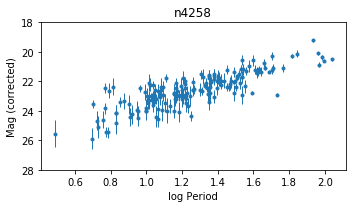

In [4]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)

ceph.select('4258')
mobs = ceph.mobs
logP = ceph.logP
sigma_obs = ceph.sigma
ax.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o',ms=3,elinewidth=1)

ax.invert_yaxis()
ax.set_title(f'n4258')
ax.set_ylim((28,18))
ax.set_xlabel(f'log Period')
ax.set_ylabel(f'Mag (corrected)')
fig.tight_layout()
plt.show()

Basically, $zp_{W,4258}$ and $b_{W}$ are the intercept and slope for 4258. By looking at the data and its plot directly, we can fairly say that $24<zp_{W,4258}<28$ and $-4<b_{W}<0$ respectively. Finally, we can estimate the range of $\sigma_{\rm int}$ via the vertical data spread on the plot, and thus $0<\sigma_{\rm int}<5$.

In [5]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def neglogLike(P,ceph):
    dim = len(P)
    mudiff = P[:dim-3]
    zpw = P[dim-3]
    bw = P[dim-2]
    sig = P[dim-1]
    neglogLike = []
    
    hosts = ceph.list_hosts()
    for i, ID in enumerate(hosts):
        ceph.select(ID)
        mobs = ceph.mobs
        logP = ceph.logP
        sigma_obs = ceph.sigma
        if (i==5):
            m_model = zpw + bw*logP
        elif (i>5):
            m_model = mudiff[i-1] + zpw + bw*logP
        else:
            m_model = mudiff[i] + zpw + bw*logP
        chi2 = (mobs - m_model)**2/(sigma_obs**2+sig**2)
        logCoef = np.log(2*np.pi*(sigma_obs**2+sig**2))
        neglogLike.append(0.5*logCoef.sum()+0.5*chi2.sum())
        
    return np.sum(neglogLike)

def logPrior(P,peaks,spreads):
    dim = len(P)
    mudiff = P[:dim-3]
    zpw = P[dim-3]
    bw = P[dim-2]
    sig = P[dim-1]    
    
    if (all((mudiff>0)) and all((mudiff<5)) and (zpw>24) and (zpw<28)\
        and (bw>-4) and (bw<0) and (sig>0) and (sig<5)):
        p=st.norm.pdf(P,loc=peaks,scale=20*spreads)
        return (np.log(p)).sum()
    else:
        return -np.inf

def logPosterior(P,ceph,peaks,spreads):    
    return logPrior(P,peaks,spreads) - neglogLike(P,ceph)

The non-top-hat priors are set up according to what have been discussed above.

In [6]:
result = minimize(fun = neglogLike, x0 = list(np.ones(8))+[27,-3,1],args=ceph)
peaks = result.x
spreads = np.diag(result.hess_inv)**0.5
print('Peak   =', peaks)
print('Spread =', spreads)

Peak   = [ 3.14844715  2.85669316  2.70115158  2.34647958  2.13140135  1.54396466
  2.27092029  2.35275359 26.18233946 -2.91365349  0.41905282]
Spread = [0.0692799  0.10652836 0.06311178 0.09586536 0.09300108 0.0728356
 0.09295224 0.06588842 0.11058001 0.06947319 0.01804722]


Using scipy.optimize.minimize to find the minimum of neglogLike (and hence the maximum of log likelihood). Printing out the peak and spread for consistency check.

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

Let's run the emcee sampler to sample the posterior distribution.

In [7]:
import emcee

ndim = 11
nwalkers = 22
nburn = 100
nsteps = 15000

np.random.seed(10)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :ndim-3] = st.uniform.rvs(1, 3, (nwalkers, ndim-3))
starting_guesses[:, ndim-3] = st.uniform.rvs(25, 2, nwalkers)
starting_guesses[:, ndim-2] = st.uniform.rvs(-3, 1, nwalkers)
starting_guesses[:, ndim-1] = st.uniform.rvs(0, 1, nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=[ceph,peaks,spreads])
_ =  sampler.run_mcmc(starting_guesses, nsteps, rstate0=np.random.get_state())

sample = sampler.chain

Discard the first 5000 iterations as burn-in processes and thin the whole chain by a factor of 10.

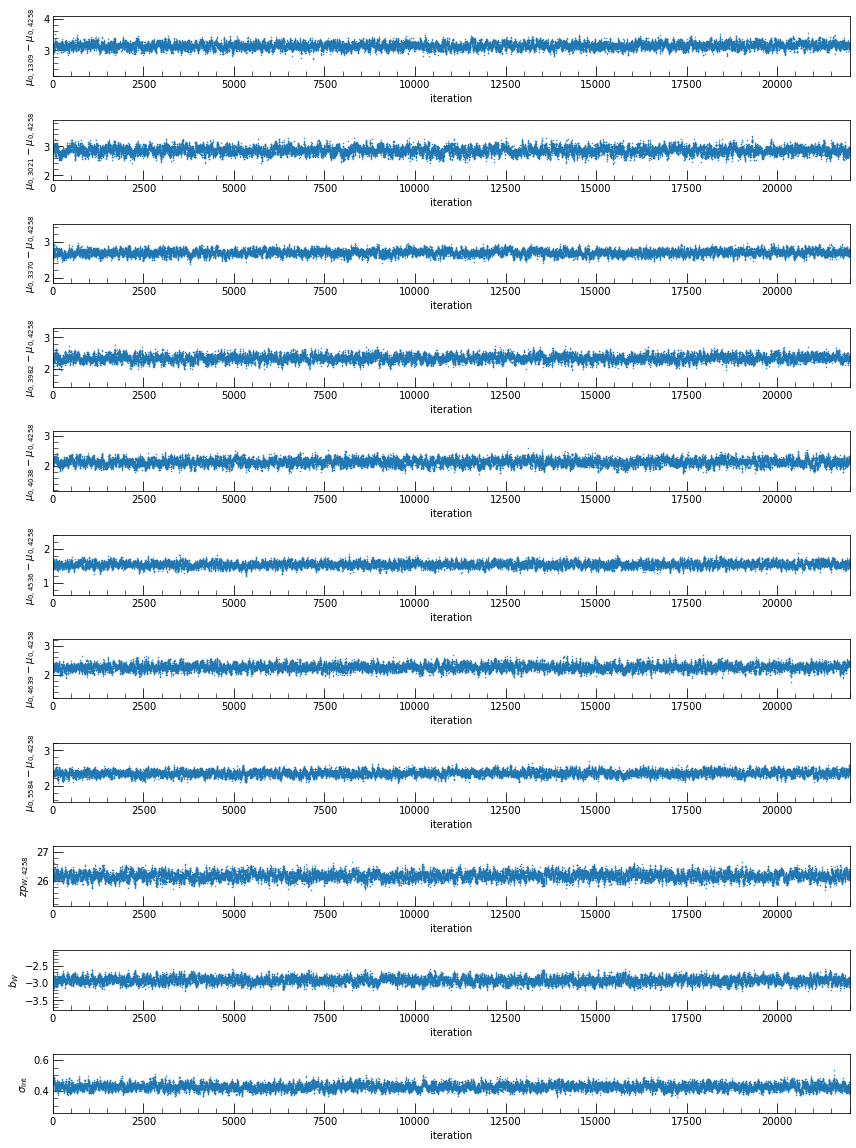

In [8]:
ylabels = []
for ID in hosts:
    if (ID != '4258'):
        ylabels.append(f'$\mu_{{0,'+ID+f'}}-\mu_{{0,4258}}$')
        
ylabels.append(r'$zp_{W,4258}$')
ylabels.append(r'$b_{W}$')
ylabels.append(r'$\sigma_{\rm int}$')

nburn = 5000
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
sample = sample[::10,:]

from matplotlib.ticker import AutoMinorLocator
fig = plt.figure(figsize=(12,16))
for i in range(ndim):
    ax = fig.add_subplot(11,1,i+1)
    ax.plot(sample[:,i],ls='',marker='.',ms=1)
    ax.set_xlabel(f'iteration')
    ax.set_ylabel(ylabels[i])
    ymin,ymax = ax.get_ylim()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='major', length=10,direction ='in')
    ax.tick_params(which='minor', length=5,direction ='in')
    ax.set_xlim([0,(nsteps-nburn)*nwalkers/10])
    if (i == (ndim-1)):
        ax.set_ylim([ymin-0.1,ymax+0.1])
    else:
        ax.set_ylim([ymin-0.5,ymax+0.5])

fig.tight_layout()
plt.show()

All of the traceplots look stable and reasonable.

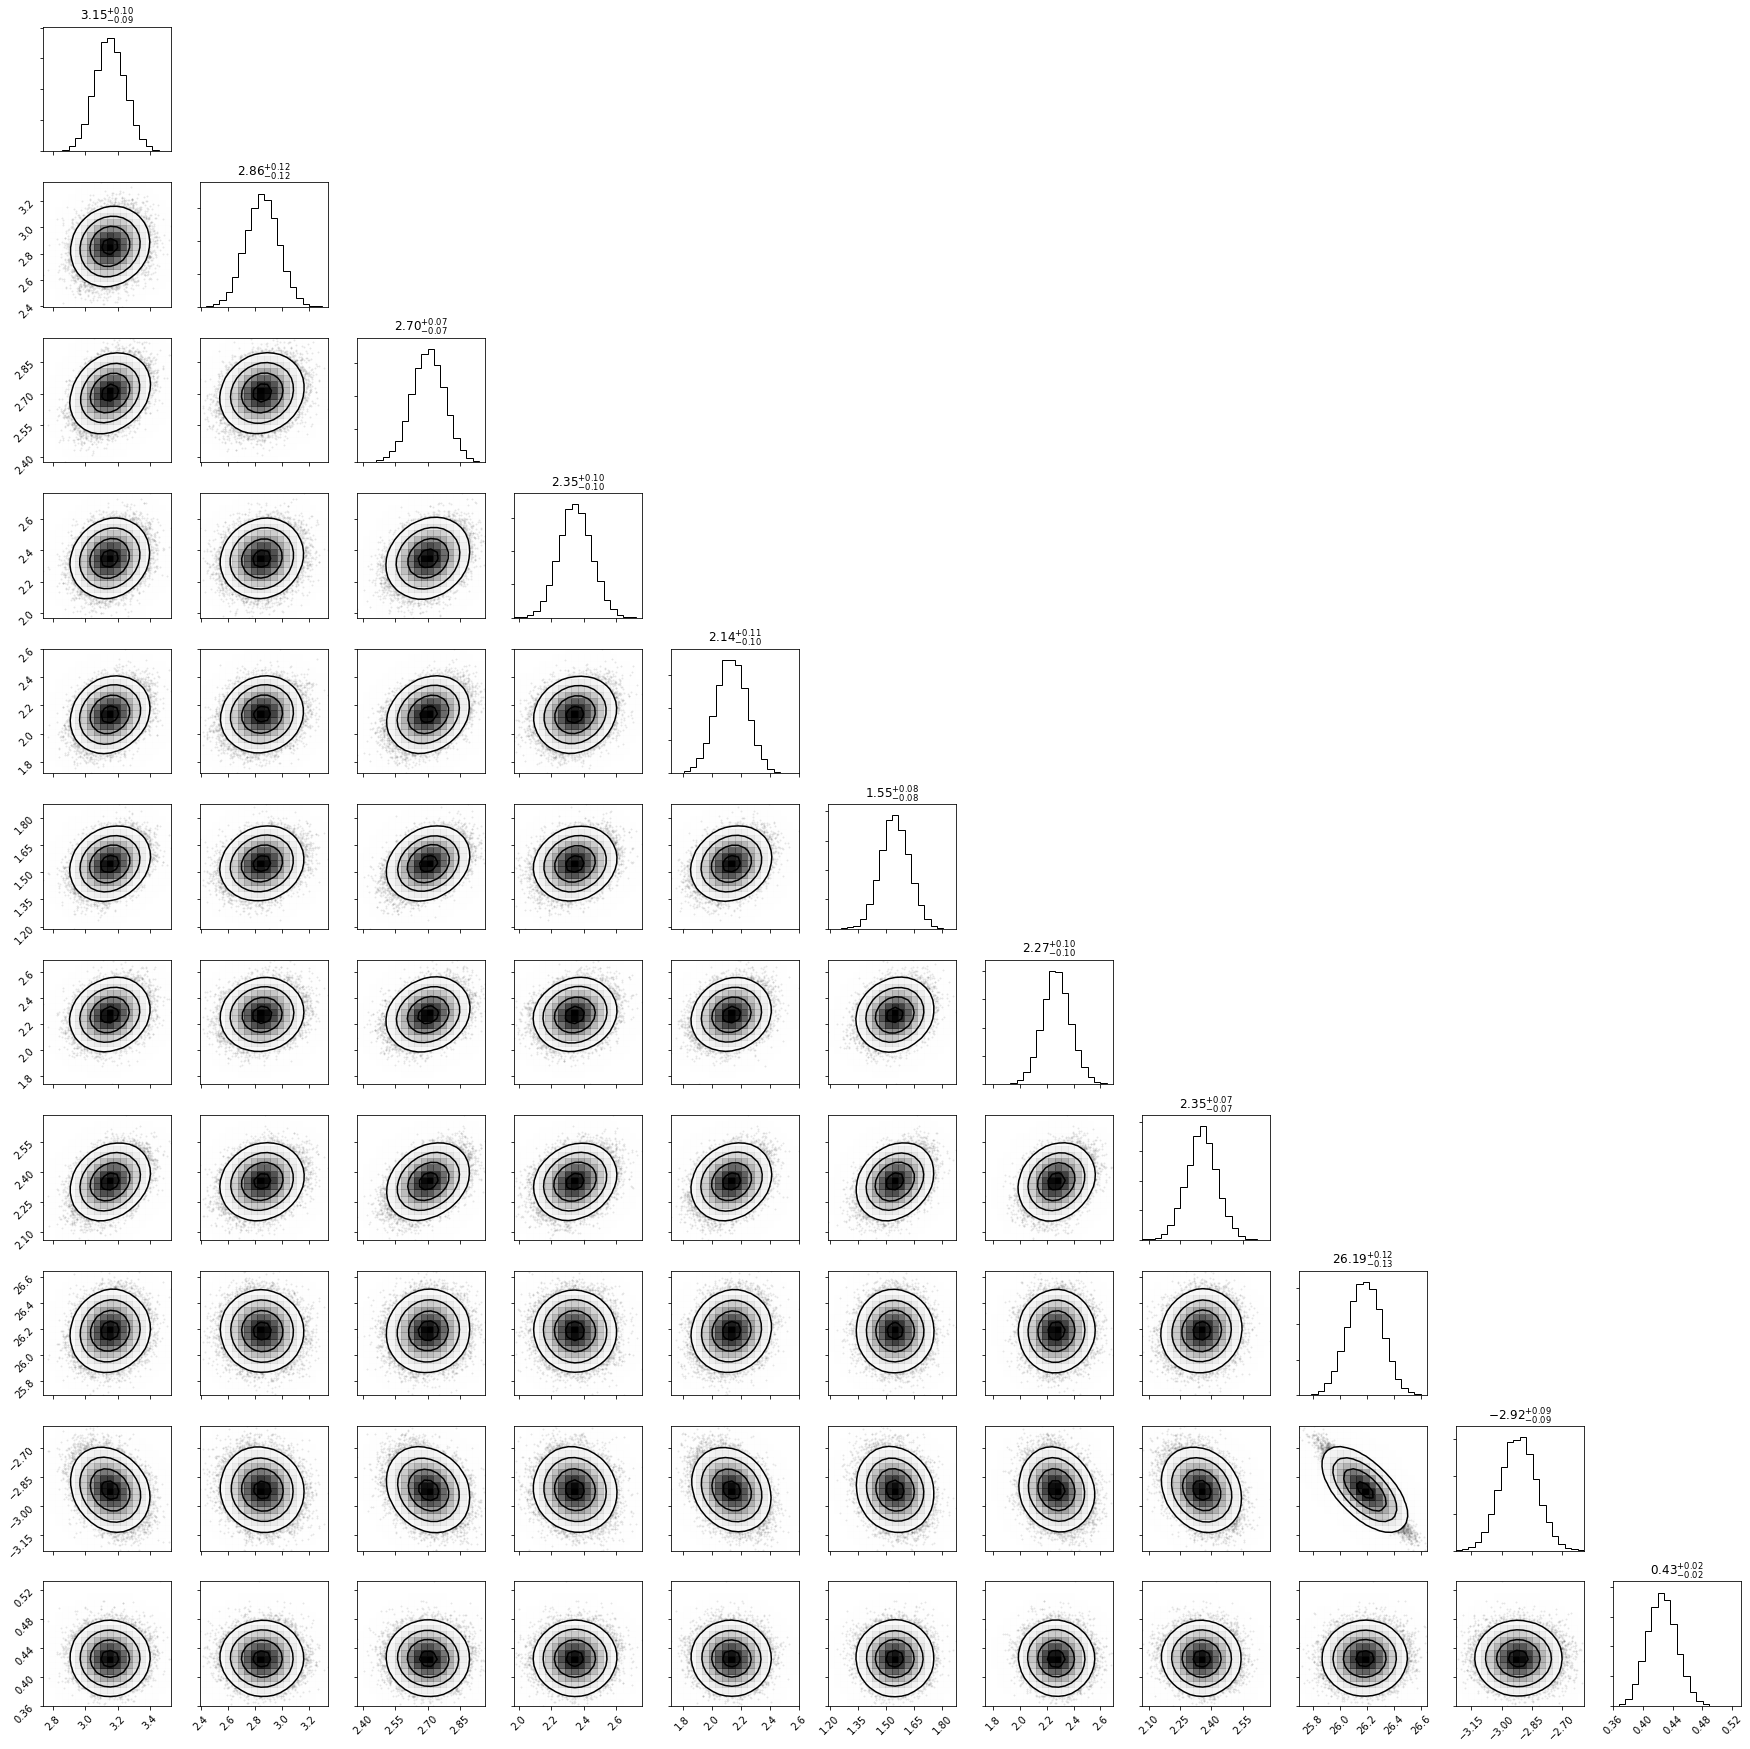

In [9]:
import corner
fig = corner.corner(sample, plot_contours=True, show_titles=True, smooth=2)
fig.tight_layout()
plt.show()

The corner plots also look good.

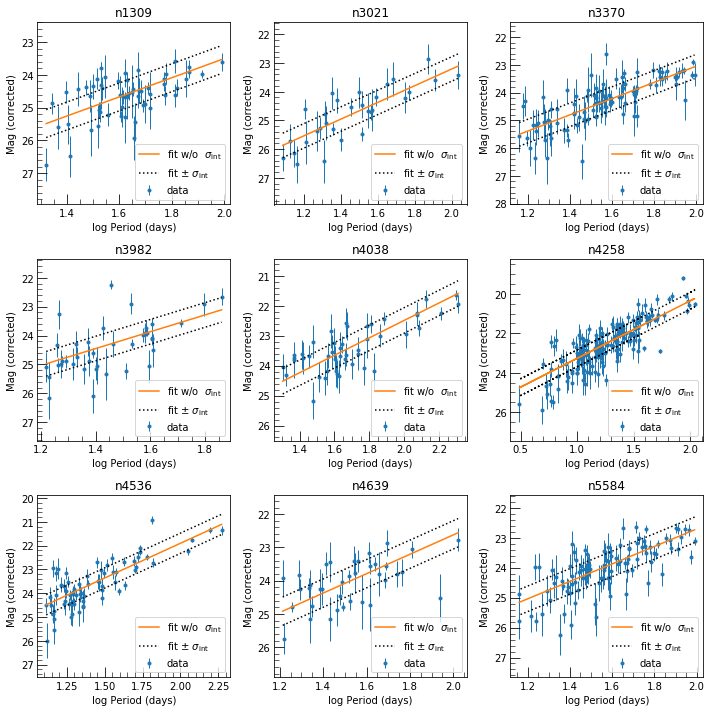

In [10]:
mcmc_res = np.percentile(sample, [50, 16, 84], axis=0)

fig = plt.figure(figsize=(10,10))
for i,ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax = fig.add_subplot(3,3,i+1)
    ax.errorbar(logP,mobs,yerr=sigma_obs,ls='',marker='o',ms=3,elinewidth=1,zorder=0,label='data')
    
    mudiff = mcmc_res[0,:ndim-3]
    zpw = mcmc_res[0,ndim-3]
    bw = mcmc_res[0,ndim-2]
    sig = mcmc_res[0,ndim-1]  
    if (i==5):
        m_fit = zpw + bw*logP
    elif (i>5):
        m_fit = mudiff[i-1] + zpw + bw*logP
    else:
        m_fit = mudiff[i] + zpw + bw*logP
    ax.plot(logP,m_fit,zorder=6,label=r'fit w/o  $\sigma_{\rm int}$')
    ax.plot(logP,m_fit+sig,zorder=5,label=r'fit $\pm$ $\sigma_{\rm int}$',ls=':',c='k',lw=1.5)
    ax.plot(logP,m_fit-sig,ls=':',c='k',lw=1.5)
    ax.set_xlabel(f'log Period (days)')
    ax.set_ylabel(f'Mag (corrected)')
    ax.set_title('n'+ID)
    ymin,ymax = ax.get_ylim()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='major', length=10,direction ='in')
    ax.tick_params(which='minor', length=5,direction ='in')
    ax.set_ylim([ymin-0.5,ymax+0.5])
    ax.invert_yaxis()
    ax.legend(loc=4)

fig.tight_layout()
plt.show()

All the lines generated by medians of our model parameters look good because they roughly pass through centers of data points by eye. I think my plots are very similar to Fig. 7 of Riess et al. 2011 except that they used the F160W magnitude while we work with corrected magnitude.

In [11]:
MyIntercept = mcmc_res[0,:ndim-3]
R11Intercept = [3.276, 3.138, 2.835, 2.475, 2.396, 1.567, 2.383, 2.461]
print(f'MyFit ',f'R11',f'   diff by')
for i in range(ndim-3):
    print(f'{MyIntercept[i]:.3f} ',R11Intercept[i],f' {100*(MyIntercept[i]-R11Intercept[i])/R11Intercept[i]:7.3f}'+' %')

MyFit  R11    diff by
3.151  3.276   -3.804 %
2.855  3.138   -9.008 %
2.703  2.835   -4.665 %
2.347  2.475   -5.162 %
2.135  2.396  -10.883 %
1.546  1.567   -1.345 %
2.270  2.383   -4.746 %
2.353  2.461   -4.377 %


My intercept fits are at most 11 percent smaller than those reported in Riess et al. 2011. Remember that our model completely ignores the effect of metalicity. This could be the reason why my fits get smaller numbers.

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

$${\rm log} H_{0} = \dfrac{(m^{0}_{v,4258}-\mu_{0,4258})+5a_{v}+25}{5} = \dfrac{(m^{0}_{v,i} +5a_{v})-(m^{0}_{v,i}  - m^{0}_{v,4258})-\mu_{0,4258}+25}{5} =  \dfrac{(m^{0}_{v,i} +5a_{v})-(\mu_{0,i}  - \mu_{0,4258})-\mu_{0,4258}+25}{5}$$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

With my own $\mu_{0,i}  - \mu_{0,4258}$ calculated above, I then use the $m^{0}_{v,i} +5a_{v}$ column in Table 3 from Riess et al., 2011 and $\mu_{0,4258} = 5\log d_{4258} - 5$ from Humphreys et al., 2013.

In [12]:
R11mv5av = np.array([16.768,16.699,16.545,15.953,15.901,15.147,16.040,16.274])
H13mu = 5*np.log10(7.6e6)-5
H0 = 10**((R11mv5av - MyIntercept - H13mu + 25)/5)
print(f'H0 = {H0.mean():.1f}'+' \u00b1 '+f'{H0.std():.1f}'+' km/s/Mpc')

H0 = 74.0 ± 3.9 km/s/Mpc


Compared with $H_{0} = 73.8 \pm 2.4$ km/s/Mpc from Riess et al., 2011 and $H_{0} = 72.0 \pm 3.0$ km/s/Mpc from Humphreys et al., 2013, my simple statistics for $H_{0}$ looks good.